# train wmn using additional generated images

In [1]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
#root_dir = os.path.dirname(parent_dir)
sys.path.insert(0, parent_dir)

In [2]:
from evaluation.fcsrn.FCSRN import fcsrn

from dataset import load_realdata
from imageGenerators.imgGen_simple import synth_generator
from imageGenerators.imgGen_augmented import synth_generator as synth_generator_new

from cyclegan.cyclegan import cyclegan

import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from time import time
import re
import random
import pickle

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

In [4]:
# Path to i2i-model to use for translating synthetic images to easy images
i2i_model =  Path("synth2easy")
i2i_epoch = 17
smallModel=True

# where to save FCSRN model
#fcsrn_model = Path("D:/m2/savedmodels/goals/q12_easy2diff_furtherMethods/method4/evaluate/fcsrn_pretrain/p5")
fcsrn_model = "test2"

continue_training = False # whether to load and continue training of fcsrn
continue_epoch = 30 # if <continue_training>, which epoch to load.

# model translating easy images to diff images, used if trainset=="generated-diff"
i2i_easy2diff = "synth2diff_2step_B"
easy2diff_epoch = 40


####
# what dataset to use for training
####
# "generated": use only generated images for training
# "real": use only real difficult images for training (original trainingset)
# "shuffle": shuffle generated and real images into a new dataset
# "easy": use only real easy images for training(n=1000)
# "easy_small": use only real easy images (train-split, n=500)
# "diff_small": use only 500 of the original 4000 real difficult training images.
# "generated-diff" translate synthethic images to easy images with  <i2i_model>,
#                     then translate those to difficult images with <i2i_easy2diff>
trainset = "real"

if trainset == "generated-diff":
    assert not i2i_easy2diff is None
    

digit_target = 1000          # how many of each digit to generate
generate_fixed_amount = True # if True, generate <digit_target> of each digit; else generate digit until number of that digit in generated and real images combined is at least <digit_target>
train_epochs = 110
batchsize = 100


postprocess = None
postprocess_name = "None" if postprocess is None else postprocess.__name__

In [5]:
N_DIGITS = 5   # digits per label
N_CLASSES = 20 # there are 10 digits and 10 midstate-digits

# dimensions of input to wmn-model
fcsrn_height = 48; fcsrn_width = 160; fcsrn_channels = 1
fcsrn_shape = (fcsrn_height, fcsrn_width, fcsrn_channels)
fcsrn_dims = (fcsrn_width, fcsrn_height)

# dimensions of cyclegan input
i2i_shape = [128,512,1]
i2i_dims = (i2i_shape[1], i2i_shape[0])



In [6]:
# functions to display image/s

def showImage(image, normalized=False):
    if normalized:
        vmin=-1; vmax=1
    else:
        vmin=0; vmax=255
    if len(image.shape) == 3 and image.shape[2] == 1:
        image = image[:,:,0]
    #image = image.astype(int)
    plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
    plt.show()
def showImages(images, n, labels=None, normalized=False):
    for i in range(min(n, len(images))):
        if not labels is None:
            print(labels[i])
        image = images[i]
        showImage(image, normalized)

In [7]:

def to3channel(images):
    shape = images.shape
    if len(shape) < 4:
        shape = [d for d in shape]
        shape.append(1)
        images = np.reshape(images, shape)
        images = np.repeat(images, 3, axis=-1)
        print(images.shape)
    return images
def to1channel(images):
    shape = images.shape
    if len(shape) < 4:
        shape = [d for d in shape]
        shape.append(1)
        images = np.reshape(images, shape)
        print(images.shape)
    return images

# Generate Images

In [8]:
####
# return map from digits(0-20) to number of each digit to generate
####
def n_digitsToGenerate():
    # map digits(0-20) to number to generate of each digit
    digitCount_map = {}
    if generate_fixed_amount:
        # generate same number of each digit
        for digit in range(20):
            digitCount_map[digit] = digit_target
    else:
        ###
        # generate each digit so that number of each digit in real+generated images adds up to target
        ### 
        #count how often each digit occurs in real images
        digits, counts = np.unique(labels_train.flatten(), return_counts=True)
        for digit in range(20):
            digitCount_map[digit] = target - counts[digit] if counts[digit] < targetDigitCount else 0
    return digitCount_map

####
# taking a map of digit-digitcount, 
# returns array of labels.
####
def targetCount_to_labels(n_toGenerate):
    # number of additional digits
    sum_additionalDigits = sum(n_toGenerate.values())
    # number of additional images
    n_additionalImages = int(sum_additionalDigits / N_DIGITS)
    # make flat ordered list containing each digit to generate
    labels_gen = np.concatenate([
        np.full(shape=count, fill_value=digit) for digit, count in n_toGenerate.items()
    ])
    # shuffle that list, then reshape to list of labels
    np.random.shuffle(labels_gen)
    labels_gen = np.reshape(labels_gen, (n_additionalImages, N_DIGITS) )
    return labels_gen

####
# taking a list of labels, generate an image for each label (using new generator)
####
def generate_synthethic_newGenerator(labels, show_generated=5):
    synthGenerator = synth_generator_new()
    images = synthGenerator.makeImages(labels, resizeTo=i2i_dims, color=True, rotate=True)
    print("synthetic images:")
    showImages(images, show_generated, labels)
    return images

In [9]:
# resize image and add padding on one dimensions to keep ratios
def resize_withPadding(image, targetWidth, targetHeight):    
    inputWidth = image.shape[1]
    inputHeight = image.shape[0]
    # scale either width or height, depending on which scaling factor would be smaller
    scale_width = targetWidth / inputWidth
    scale_height = targetHeight / inputHeight
    
    if scale_width < scale_height:
        # scale width, pad height
        result = cv2.resize(image, dsize=(0,0), fx=scale_width, fy=scale_width)
        padding = targetHeight - result.shape[0]
        p_top = int(padding/2)
        p_bot = p_top if (padding%2) == 0 else p_top + 1
        assert padding >= 0 and (p_top + p_bot) == padding, "unexpected height-padding: %d"%(padding)
        result = cv2.copyMakeBorder(result, top=p_top, bottom=p_bot, left=0, right=0, borderType=cv2.BORDER_CONSTANT,value=0)
    else:
        # scale height, pad width
        result = cv2.resize(image, dsize=(0,0), fx=scale_height, fy=scale_height)
        padding = targetWidth - result.shape[1]
        p_left = int(padding/2)
        p_right = p_left if (padding%2) == 0 else p_left + 1
        assert padding >= 0 and (p_left + p_right) == padding, "unexpected width-padding: %d"%(padding)
        result = cv2.copyMakeBorder(result, top=0, bottom=0, left=p_left, right=p_right, borderType=cv2.BORDER_CONSTANT,value=0)                                    
    return result

In [10]:
# translate synthetic images into realistic images using cyclegan
def translate_images(modelPath, modelEpoch, synthImages, resultDims, keepRatio = True, show_generated=5, postprocess=None):
    ####
    # load i2i model - most parameters dont matter when not training
    cgModel = cyclegan(i2i_shape,-1,-1, "mse", checkpoint_path=modelPath, load_checkpoint_after_epoch=modelEpoch, smallModel=smallModel)
    # prepare input for cgan
    cgan_input = tf.data.Dataset.from_tensor_slices(synthImages)\
                .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE)\
                .cache()\
                .batch(1)

    ####
    # predict realistic images
    translated_images = cgModel.gen_AtoB.predict(cgan_input)
    
    # denormalize
    translated_images = (translated_images + 1) * 127.5    
    if not postprocess is None:
        # distortionfunctions operate on images in range 0-255, so cast to int
        translated_images = translated_images[:,:,:,0].astype("uint8")
        #translated_images = translated_images[:,:,:,0]
        for image in translated_images:            
            postprocess(image)
        # cast back to float
        translated_images = translated_images.astype("float32")
    #import pdb; pdb.set_trace()       
    #assert False, "todo: postprocess funktioniert noch nicht so recht"
    
    # resize to inputshape of wmn-model
    if keepRatio:
        width, height = resultDims
        translated_images = np.array([
            resize_withPadding(image, width, height) for image in translated_images
        ])
    else:       
        translated_images = np.array([
            cv2.resize(image, resultDims) for image in translated_images
        ])
        
                
        
    print("translated images:")
    showImages(translated_images, show_generated)    
    return translated_images

In [11]:
# pipeline from labels to generated easy images
def pipeline_generateImages(show_images=5):
    digitCount_map = n_digitsToGenerate()
    labels_synth = targetCount_to_labels(digitCount_map)
    images_synth = generate_synthethic_newGenerator(labels_synth, show_images)
    images_translated = translate_images(i2i_model, i2i_epoch, images_synth, fcsrn_dims, keepRatio=True, show_generated=show_images, postprocess=postprocess)
    return images_translated, labels_synth

# pipeline from labels to generated easy images, then translated to difficult images
def pipeline_diffImages(show_images=5):
    digitCount_map = n_digitsToGenerate()
    labels_synth = targetCount_to_labels(digitCount_map)
    images_synth = generate_synthethic_newGenerator(labels_synth, show_images)
    translated_easy = translate_images(i2i_model, i2i_epoch, images_synth, i2i_dims, keepRatio=False, show_generated=show_images, postprocess=postprocess)
    translated_diff = translate_images(i2i_easy2diff, easy2diff_epoch, translated_easy, fcsrn_dims, keepRatio=True, show_generated=show_images, postprocess=postprocess)
    return translated_diff, labels_synth
    

def generateImages_test(n_testimages):
    labels = np.random.randint(0,20, (n_testimages, N_DIGITS))
    images_synth = generate_synthethic_newGenerator(labels, 0)
    images_translated = translate_images(i2i_model, i2i_epoch, images_synth, fcsrn_dims, keepRatio=True, show_generated=0, postprocess=postprocess)
    return images_translated, labels
    
def generateImages_test_diff(n_testimages):
    labels = np.random.randint(0,20, (n_testimages, N_DIGITS))
    images_synth = generate_synthethic_newGenerator(labels, 0)
    translated_easy = translate_images(i2i_model, i2i_epoch, images_synth, i2i_dims, keepRatio=False, show_generated=0, postprocess=postprocess)
    translated_diff = translate_images(i2i_easy2diff, easy2diff_epoch, translated_easy, fcsrn_dims, keepRatio=True, show_generated=0, postprocess=postprocess)
    return translated_diff, labels

In [12]:
def make_dataset(list):
    return tf.data.Dataset.from_tensor_slices(list)\
        .cache() \
        .batch(batchsize, drop_remainder=False)

# prepare tf.dataset of trainingdata. dataset must be either "generated", "real", "shuffle"
def pipeline_makeTrainDatasets(trainset):    
    
    if trainset == "generated":
        images_translated, labels_synth = pipeline_generateImages(show_images=100)
        images_translated = to1channel(images_translated).astype("float32")
        
        image_ds = make_dataset(images_translated)
        labels_ds = make_dataset(labels_synth)
        
    elif trainset == "generated-diff":
        images_translated, labels_synth = pipeline_diffImages(show_images=100)
        images_translated = to1channel(images_translated).astype("float32")
        image_ds = make_dataset(images_translated)
        labels_ds = make_dataset(labels_synth)
        
    elif trainset == "real":
        images_real, labels_real = load_realdata.load_wmr_diff_train(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, processImage=None)
        #images_real = to3channel(images_real).astype("float32")
        images_real = to1channel(images_real).astype("float32")
        
        image_ds = make_dataset(images_real)
        labels_ds = make_dataset(labels_real)
        
    elif trainset == "easy_small":
        data_easy_train, _ = load_realdata.load_wmr_easy_split(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, processImage=None, channels=1)
        images_real, labels_real = data_easy_train
        #images_real = to3channel(images_real).astype("float32")
        images_real = images_real.astype("float32")
        
        image_ds = make_dataset(images_real)
        labels_ds = make_dataset(labels_real)
        
    elif trainset == "diff_small":
        images_real, labels_real = load_realdata.load_diff_split(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, processImage=None, channels=1)
        images_real = images_real.astype("float32")
        print("about diff_small:")
        print(images_real.shape)
        
        image_ds = make_dataset(images_real)
        labels_ds = make_dataset(labels_real)
        
    elif trainset == "shuffle":
        # append generated data to real data and shuffle result
        images_translated, labels_synth = pipeline_generateImages(show_images=5)
        images_translated = to1channel(images_translated).astype("float32")
        images_real, labels_real = load_realdata.load_wmr_diff_train(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, processImage=None)
        images_real = to1channel(images_real).astype("float32")
        
        images_real = np.append(images_real, images_translated, axis=0)
        labels_real = np.append(labels_real, labels_synth, axis=0)
        zip_real = list(zip(images_real, labels_real))
        random.shuffle(zip_real)    
        images_real, labels_real = zip(*zip_real)
        images_real = np.array(images_real)
        labels_real = np.array(labels_real)
        image_ds = make_dataset(images_real)
        labels_ds = make_dataset(labels_real)
    elif trainset == "easy":
        images_real, labels_real = load_realdata.load_wmr_easy(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, processImage=None)
        images_real = to1channel(images_real).astype("float32")
        
        image_ds = make_dataset(images_real)
        labels_ds = make_dataset(labels_real)
    
    else:
        raise Exception("unknown trainset: %s" % (trainset) )
            
    
    return (image_ds, labels_ds)

In [13]:
# make traindatasets
stime = time()
image_ds, labels_ds = pipeline_makeTrainDatasets(trainset)
print("pipeline took %.2f seconds" % (time() - stime) )


# prepare testdata
test_X_realEasy, test_y_realEasy = load_realdata.load_wmr_easy(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, channels=1)
test_X_realDiff, test_y_realDiff = load_realdata.load_wmr_diff_test(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, channels=1)


if trainset == "generated-diff":
    test_X_gen, test_y_gen = generateImages_test_diff(1000)
    test_X_gen = to1channel(test_X_gen)#.astype("float32")
else:
    test_X_gen, test_y_gen = generateImages_test(1000)
    test_X_gen = to1channel(test_X_gen)#.astype("float32")


C:\Users\andre\Desktop\m\schriftlich\master\code\dataset\load_realdata.py:62: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(txt_path, sep=seperators ,header=None)


(4000, 48, 160, 1)
pipeline took 4.40 seconds
synthetic images:
loaded checkpoint:  C:\Users\andre\Desktop\m\schriftlich\master\code\cyclegan\saved_models\synth2easy\epoch-17
translated images:
(1000, 48, 160, 1)


-------------------
	Sample of trainingdata
40 batches of shape (100, 48, 160, 1)
tf.Tensor([ 0  0  7 17 19], shape=(5,), dtype=int32)


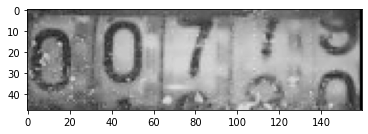

tf.Tensor([0 1 3 8 8], shape=(5,), dtype=int32)


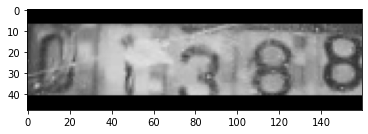

tf.Tensor([ 0  1  5  6 13], shape=(5,), dtype=int32)


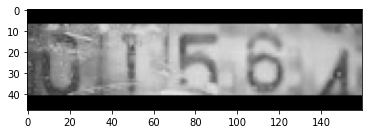

tf.Tensor([0 0 8 1 3], shape=(5,), dtype=int32)


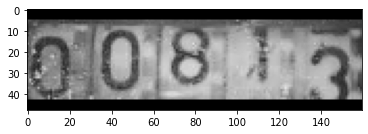

tf.Tensor([ 0  1  8  3 19], shape=(5,), dtype=int32)


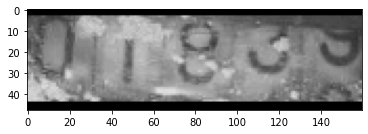

tf.Tensor([ 0  1  1 11 18], shape=(5,), dtype=int32)


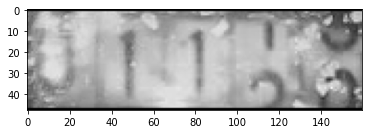

tf.Tensor([ 0  1  6  4 12], shape=(5,), dtype=int32)


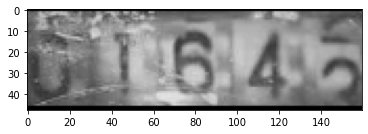

tf.Tensor([0 1 2 7 0], shape=(5,), dtype=int32)


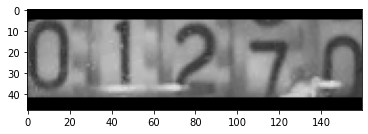

tf.Tensor([ 0  1  2  9 12], shape=(5,), dtype=int32)


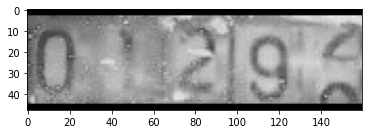

tf.Tensor([0 0 7 2 7], shape=(5,), dtype=int32)


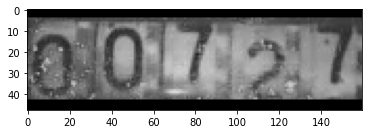

In [14]:
# show some trainingimages
train_sample = next(iter(image_ds))
label_sample = next(iter(labels_ds))
n_batches = tf.data.experimental.cardinality(image_ds)
print("-------------------")
print("\tSample of trainingdata")
print("%d batches of shape %s" % (n_batches,train_sample.shape) )
showImages(train_sample, 10, labels=label_sample, normalized=False)

In [15]:
# for each of these testsets, AR will be calculated and saved to a file
testSet = [
    # name,       images,          labels
    ("generated",  test_X_gen,      test_y_gen),       # generated images
    ("real_easy", test_X_realEasy, test_y_realEasy ), # real_easy images
    ("real_diff", test_X_realDiff, test_y_realDiff ), # real_difficult images
]

if trainset == "easy_small":
    _, data_easy_test = load_realdata.load_wmr_easy_split(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, processImage=None,channels=1)
    images_easy_test, labels_easy_test = data_easy_test
    testSet.append(
        ("real_easy_testSplit", images_easy_test, labels_easy_test)
    )

In [16]:
#print(testSet[0][1].dtype)
#print(testSet[1][1].dtype)
#print(testSet[2][1].dtype)
#print(testSet[3][1].dtype)

In [17]:

if continue_training:
    # load a pretrained model
    model = fcsrn(fcsrn_shape, checkpoint_path=fcsrn_model, epoch_to_load=continue_epoch)
    # create a new subdir for training
    fcsrn_model = fcsrn_model/ ( "next_after_%d" % (continue_epoch) )
    assert not fcsrn_model.exists(), ( "cant continue training. path already exists: %s" %( str(fcsrn_model) ) )
    fcsrn_model.mkdir()
    model.set_checkpointDir(fcsrn_model)
else:
    # start training on a fresh model
    model = fcsrn(fcsrn_shape, checkpoint_path=fcsrn_model, epoch_to_load=None)

created new Model


In [18]:
print("training for %d epochs" % (train_epochs) )
model.train(image_ds, labels_ds, train_epochs, batchsize, testSet, checkpointInterval=1)

training for 110 epochs
40/40 [==============================] - 47s 1s/step
epoch 1 took: 46.99 seconds
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
ar_generated(epoch=1)=0.053400	4.639343seconds
ar_real_easy(epoch=1)=0.073000	0.941469seconds
ar_real_diff(epoch=1)=0.236400	0.937522seconds
saved to: C:\Users\andre\Desktop\m\schriftlich\master\code\evaluation\fcsrn\saved_models\test2\epoch-1
40/40 [==============================] - 41s 1s/step
epoch 2 took: 41.40 seconds
ar_generated(epoch=2)=0.072200	1.131967seconds
ar_real_easy(epoch=2)=0.106200	0.941481seconds
ar_real_diff(epoch=2)=0.337800	0.939487seconds
saved to: C:\Users\andre\Desktop\m\schriftlich\master\code\evaluation\fcsrn\saved_models\test2\epoch-2
40/40 [==============================] - 40s 997ms/step
epoch 3 took: 39.90 seconds
ar_generated(epoch=3)=0.072200	1.140978seconds
ar_real_easy(epoch=3)=0.106200	0.937475seconds
ar_real_diff(epoch=3)=0.338200	0.939485seconds
sa

KeyboardInterrupt: 